In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
plt.style.use('ggplot')

In [2]:
# Read dataset
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Reviews.csv')
df = df.head(1000)

In [3]:
df.shape

(1000, 10)

In [4]:
# EDA
df_scores = df['Score'].value_counts().sort_index().to_frame().reset_index()\
            .rename(columns={'Score':'Count','index':'Score'})
df_scores

,Score,Count
0,1,98
1,2,47
2,3,75
3,4,138
4,5,642


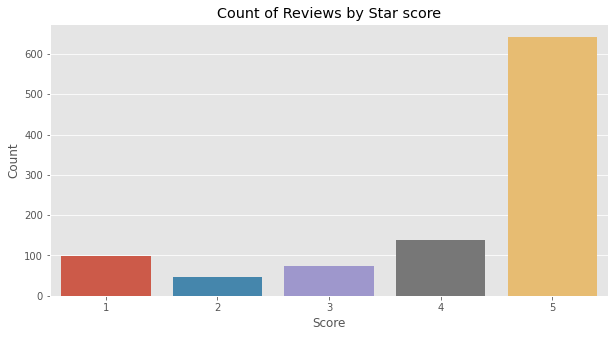

In [5]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_scores, x='Score', y='Count').\
            set(title='Count of Reviews by Star score')
plt.show()

In [6]:
df['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# NLTK VADER Sentiment Analysis

In [8]:
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [9]:
sia.polarity_scores("It's a great sunny day but I am feeling tired!")

{'neg': 0.268, 'neu': 0.279, 'pos': 0.453, 'compound': 0.1635}

In [10]:
ps = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  id = row['Id']
  ps[id] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
vaders_df = pd.DataFrame(ps).T.reset_index(). \
            rename(columns={'index':'Id'})
vaders_df = vaders_df.merge(df, how='left')
vaders_df.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


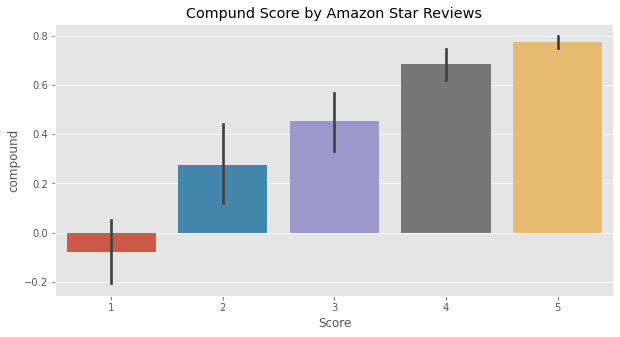

In [12]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=vaders_df, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Reviews')
plt.show()

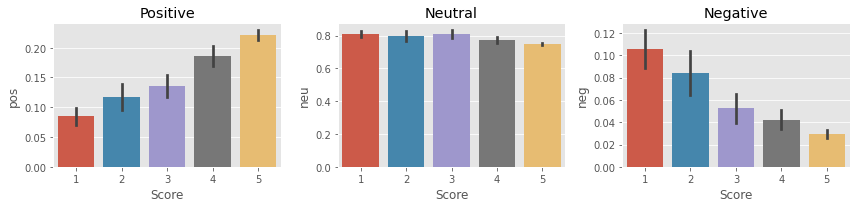

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders_df, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders_df, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders_df, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.4 MB/s eta 0:00:00


# Sentiment Analysis using Transformer

In [15]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [16]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [17]:
# Run for Roberta Model
example = "It's a great sunny day but I am feeling tired!"
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.18266872, 'roberta_neu': 0.29882622, 'roberta_pos': 0.5185051}


In [18]:
sia.polarity_scores("It's a great sunny day but I am feeling tired!")

{'neg': 0.268, 'neu': 0.279, 'pos': 0.453, 'compound': 0.1635}

In [19]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [20]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [22]:
results_df = pd.DataFrame(res).T.reset_index().\
              rename(columns={'index': 'Id'}).\
              merge(df, how='left')

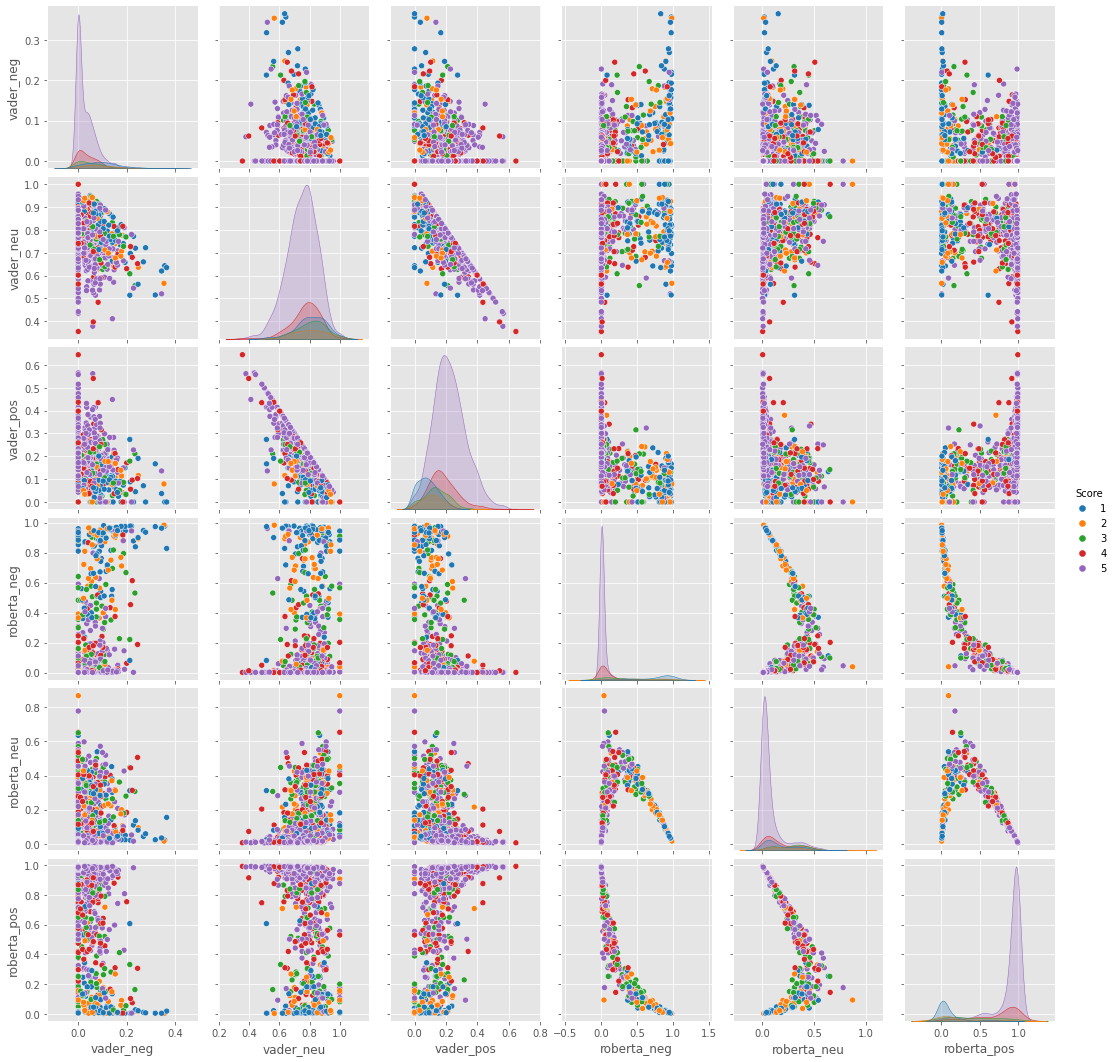

In [23]:
sns.pairplot(data=results_df,
              vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
              hue='Score',
              palette='tab10')
plt.show()